# Inferencia
### Metodo para la inferencia de nodos

Se desea realizar un programa en python que se encargue de las tareas de:

* ~~1) Recibir datos del cuestionario.~~
* ~~2) Cargar una red bayesiana en formato BIFXML.~~
* ~~3) Definir estructura de la sub-red bayesiana (red bayesiana temporal).~~
* ~~4) Generar los CPTS de la sub-red bayesiana.~~
* ~~5) Obtener las probabilidades a posteriori de la sub-red (Médiante los métodos propuestos).~~
* 6) Clasificar los nodos de la sub-red bayesiana.
* 7) Obtener un tema objetivo (siguiente nodo a evaluar).
* 8) Actualizar la red maestra.
* 9) Almacenar la red maestra actualizada en formato BIFXML.

**Programa que tome como entrada:**
* Un grafo (vertices y aristas).
* Nodo pregunta.
* Las tablas de probabilidad condicional de cada nodo.
* Evidencias de los nodos.

**El programa debe obtener por salida:**
* Grafo ponderado con probabilidades a posteriori.
* Categorización de los nodos.

![Diagrama de MPCN](inferencia.PNG "Title")

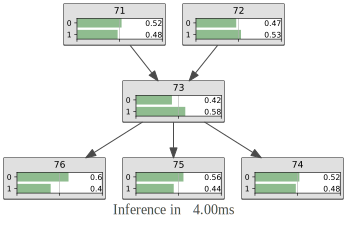


             ||  73               |
71    |72    ||0        |1        |
------|------||---------|---------|
0     |0     || 0.4227  | 0.5773  |
1     |0     || 0.4202  | 0.5798  |
0     |1     || 0.4199  | 0.5801  |
1     |1     || 0.4242  | 0.5758  |


      ||  76               |
73    ||0        |1        |
------||---------|---------|
0     || 0.6038  | 0.3962  |
1     || 0.6054  | 0.3946  |


      ||  75               |
73    ||0        |1        |
------||---------|---------|
0     || 0.5550  | 0.4450  |
1     || 0.5583  | 0.4417  |


      ||  74               |
73    ||0        |1        |
------||---------|---------|
0     || 0.5189  | 0.4811  |
1     || 0.5219  | 0.4781  |


  71               |
0        |1        |
---------|---------|
 0.5231  | 0.4769  |


  72               |
0        |1        |
---------|---------|
 0.4721  | 0.5279  |



In [10]:
# sys.argv devuelve una lista con los parametros pasados por bash.
# sys.argv[1] -> Tendrá el id del nodo evaluado objetivamente.
# sys.argv[2] -> Tendrá la calif. obtenida en el tema evaluado.
import sys
import pyAgrum.lib.notebook as gnb
import pyAgrum as gum
import requests
import numpy as np

class MPCN:
    def __init__(self, parametros):
        self.nodoEvidencia = parametros[1]
        self.ponderacionEvidencia = int(parametros[2])
        self.saltos = int(parametros[3])
        self.rangoDeAprovechamiento = 0
        
        # 0 - Bajo
        # 1 - Regular
        # 2 - Bueno
        
        if self.ponderacionEvidencia > 0 and self.ponderacionEvidencia <= 66:
            self.rangoDeAprovechamiento = 0
        elif self.ponderacionEvidencia > 66 and self.ponderacionEvidencia <= 83:
            self.rangoDeAprovechamiento = 1
        else:
            self.rangoDeAprovechamiento = 2
        
        #TO-DO: Validaciones
        self.redBayesiana = ""
        self.subRedBayesiana = ""
        
    def cargarRedBayesiana(self, ruta):
        self.redBayesiana=gum.loadBN(ruta)    
        #gnb.showBN(self.redBayesiana,size=60)
        
    def eliminarRepetidos(self,m):
        if len(m) > 0:
            sr = []
            sr.append(m[0])
            for i in range(1, len(m)):
                v=0
                for a in sr:
                    if m[i]== a:
                        v=1
                if v==0:
                    sr.append(m[i])
            return sr
    
    def crearConexionesEnSubred(self, caminos, nodoCentral, esHaciaArriba):
        conexionesEnString = []
        for camino in caminos:
            if esHaciaArriba == True:
                camino.append(str(nodoCentral))
            else:
                camino.insert(0, str(nodoCentral))
                
            for i in range(len(camino)-1):
                conexionEnString = str(camino[i]) + "->" + str(camino[i+1])
                yaExisteConexion = False
                for conexion in conexionesEnString:
                    if(conexionEnString == conexion):
                        yaExisteConexion = True
                        break
                conexionesEnString.append(conexionEnString)
                if(yaExisteConexion==False):
                    self.subRedBayesiana.addArc( str(camino[i]), str(camino[i+1]) )

    # Retorna una red bayesiana => PyAgrum
    def definirSubRedBayesiana(self):
        caminosAbajo = []
        caminosArriba = []
        nodosDeLaSubRed = []
        adelante=[]
        atras=[]
        self.subRedBayesiana = gum.BayesNet('subred')
        self.subRedBayesiana.add(gum.LabelizedVariable(str(self.nodoEvidencia),str(self.nodoEvidencia),2))
        URL = "http://167.99.228.145/arbol/caminoslibreria"
        respuestaServidor = requests.get(url = URL)
        data = respuestaServidor.json()
        caminos = data['caminos']
        
        for a in caminos:
            for i in range(len(a)):
                if a[i] == int(self.nodoEvidencia):
                    if len(a)-1-i >=self.saltos:
                        adelante.append(a[i+1:i+ (self.saltos+1) ])
                    else:
                        adelante.append(a[i+1:i+len(a)-i]) 
                    if i >=3:
                        atras.append(a[i-self.saltos:i])
                    else:
                        atras.append(a[0:i])
        
        caminosAbajo = self.eliminarRepetidos(adelante)
        caminosArriba = self.eliminarRepetidos(atras)
        for camino in caminosAbajo: nodosDeLaSubRed += camino
        for camino in caminosArriba: nodosDeLaSubRed += camino
            
        nodosDeLaSubRed = self.eliminarRepetidos(nodosDeLaSubRed)
        
        for nodo in nodosDeLaSubRed:
            self.subRedBayesiana.add(gum.LabelizedVariable(str(nodo),str(nodo),2)) # ID, NOMBRE, ESTADOS
        
        self.crearConexionesEnSubred(caminosAbajo, self.nodoEvidencia, False)
        self.crearConexionesEnSubred(caminosArriba, self.nodoEvidencia, True)
        
        #gnb.showBN(self.subRedBayesiana,size=60)
                
                
    def cargarCPTSSubRedBayesiana(self):
        copiaRedBayesiana = self.redBayesiana
        
        nodosSubRed = self.subRedBayesiana.nodes()
        for nodo in nodosSubRed:
            nombreNodo = str(self.subRedBayesiana.variable(nodo).name())
            padresSubRedBayesiana = self.subRedBayesiana.parents(self.subRedBayesiana.idFromName(nombreNodo))
            padresRedBayesianaMaestra = self.redBayesiana.parents(nombreNodo)

            for padreRBM in padresRedBayesianaMaestra:
                coincidecia = False
                nodoPadreRedBayesiana = self.redBayesiana.variable(padreRBM).name()
                for padre in padresSubRedBayesiana:
                    nodoPadreSubRedBayesiana = self.subRedBayesiana.variable(padre).name()
                    if nodoPadreRedBayesiana == nodoPadreSubRedBayesiana:
                        coincidecia = True
                        break
                
                if not coincidecia:
                    copiaRedBayesiana.eraseArc(copiaRedBayesiana.idFroName(nodoPadreRedBayesiana), copiaRedBayesiana.idFromName(nombreNodo))
                    
            self.subRedBayesiana.cpt(nombreNodo).fillWith(copiaRedBayesiana.cpt(nombreNodo))
            
    
    def calcularInferenciaSubRed(self):
        ie=gum.LazyPropagation(self.subRedBayesiana)
        #ie.addEvidence('nodo', <valor>)
        #ie.makeInference()
        #gnb.showProba(ie.posterior("73"))
        
        #gnb.showInference(self.subRedBayesiana,evs={str(self.nodoEvidencia): self.rangoDeAprovechamiento},size=60)
        
        
        gnb.showInference(self.subRedBayesiana,evs={},size=60)
        
        nodosSubRed = self.subRedBayesiana.nodes()
        for nodo in nodosSubRed:
            nombreNodo = str(self.subRedBayesiana.variable(nodo).name())
            print(self.subRedBayesiana.cpt(nombreNodo))
        
        #nombreNodo = str(self.subRedBayesiana.variable("36").name())
        #print(self.RedBayesiana.cpt(nombreNodo))
            
        
# mpcn = MPCN(sys.argv) Asi se hará en producción. En bash <python MPCN.py 'id_nodo' 'ponderación' 'saltos'>
mpcn = MPCN(['MPCN.py','73','40','1'])
mpcn.cargarRedBayesiana("bn_ids_dos_estados.bifxml")
mpcn.definirSubRedBayesiana()
mpcn.cargarCPTSSubRedBayesiana()
mpcn.calcularInferenciaSubRed()
